# Compare Readouts vs bpR2

Author: Vito Zanotelli

The goal of this analysis is to compare the results of using bpR2 vs Spearman/Pearson correlation vs DREMI (Conditional density-based analysis of T cell signaling in single-cell data, Science 2014). The cutoff is chosen to be the 99percentile of the negative controls.

The bpR2/Spearman/Pearson were calculated using the Adnet script.
The DREMI value was calculated using the reference matlab GUI implementation from the DREMI paper (from https://www.c2b2.columbia.edu/danapeerlab/html/dremi.html) modified to write out the results as a .csv file.

This script reproduces supplementary figure 11.

In [1]:
from  __future__ import division
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import numpy as np
# install matplotlib venn via: pip install matplotlib_venn
from matplotlib_venn import venn3, venn3_circles
%matplotlib inline  

Set the file paths

In [2]:
# the bin_dat pickle file, outputed by the adnet analysis script
bin_dat_fn = '../example/example_output/main_full/bindat'
# exported from the matlab dremi gui
dremi_fn = './additional_data/20160314_dremi_values_all_overexpressions.csv'
# a dictionary with the old and new names
name_dict = '../example/name_dict.csv'
out_folder = '../example/example_output/main_full/'
neg_ctrl_names = ['empty-1','empty-2','GFP-FLAG-1','GFP-FLAG-2']
# neg_ctrl_names = ['empty-1','empty-2']

For this analysis the non signaling cell cycle markers were excluded as they show quite strong multimodal relationships also in the GFP-FLAG controls. As DREMI is sensistive for such patterns, a unfair high cuttoff would be chosen for DREMI, making it look worse than it is.
An alternative is to not use the GFP-FLAG controls and not to exclude any markers (commented out lines). In this case DREMI recovers a lot of cell-cycle interactions but misses out on many relevant ones.


In [3]:
# markers that are excluded from the analysis 
excluded_names = ['cleaved PARP-cleaved caspase3', 'cyclin B1', 'p-4EBP1', 'p-HH3', 'p-RB', 'beads']
#excluded_names =[]

Load the binned data file

In [4]:
bin_dat = pd.read_pickle(bin_dat_fn)
bin_dat.index.get_level_values('target').unique()


Index([u'Beta-catenin', u'E-cadherin', u'beads',
       u'cleaved PARP-cleaved caspase3', u'cyclin B1', u'p-4EBP1', u'p-AKT',
       u'p-AMPKalpha', u'p-BTK', u'p-CREB', u'p-ERK1-2', u'p-FAK',
       u'p-GSK3-Beta', u'p-HH3', u'p-JNK', u'p-MAPKAPK2', u'p-MARCKS',
       u'p-MEK1-2', u'p-MKK3', u'p-MKK3-6', u'p-NfkB', u'p-PDPK1', u'p-PLCg2',
       u'p-RB', u'p-S6', u'p-SHP2', u'p-SMAD1-5', u'p-SMAD2-3', u'p-STAT1',
       u'p-STAT3', u'p-STAT5', u'p-mTOR', u'p-p38', u'p-p70S6K', u'p-p90RSK'],
      dtype='object', name=u'target')

Prepare the name dict


In [5]:
name_dict = pd.read_csv(name_dict)
name_dict = {row['old']: row['new'] for idx, row in name_dict.iterrows()}

Read the DREMI data

In [6]:
dat_dremi = pd.read_csv(dremi_fn, sep=',',index_col=False)
dat_dremi.head()


,origin,target,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150406/gated/BaseFileName_B10_cell_SRC-GFP EGF 60min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150406/gated/BaseFileName_B11_cell_MAP2K6-GFP EGF 60min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150406/gated/BaseFileName_B2_cell_SRC-GFP EGF 0min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150406/gated/BaseFileName_B3_cell_MAP2K6-GFP EGF 0min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150406/gated/BaseFileName_B4_cell_SRC-GFP EGF 5min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150406/gated/BaseFileName_B5_cell_MAP2K6-GFP EGF 5min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150406/gated/BaseFileName_B6_cell_SRC-GFP EGF 15min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150406/gated/BaseFileName_B7_cell_MAP2K6-GFP EGF 15min.fcs,...,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150605/gated/BaseFileName_G10_cell_MAP2K7-GFP EGF 60min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150605/gated/BaseFileName_G11_cell_Empty-GFP EGF 60min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150605/gated/BaseFileName_G2_cell_MAP2K7-GFP EGF 0min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150605/gated/BaseFileName_G3_cell_Empty EGF 0min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150605/gated/BaseFileName_G4_cell_MAP2K7-GFP EGF 5min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150605/gated/BaseFileName_G5_cell_Empty-GFP EGF 5min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150605/gated/BaseFileName_G6_cell_MAP2K7-GFP EGF 15min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150605/gated/BaseFileName_G7_cell_Empty-GFP EGF 15min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150605/gated/BaseFileName_G8_cell_MAP2K7-GFP EGF 30min.fcs,/mnt/imls-bod/Xiao-Kang/EGF transfection/20150605/gated/BaseFileName_G9_cell_Empty-GFP EGF 30min.fcs
0,gfp,idu,0.12445,0.001861,0.17874,0.000000,0.11858,0.000000,0.095233,0.000000,...,0.032370,0.22224,0.144480,0.102980,0.137430,0.232220,0.180840,0.078002,0.009091,0.132090
1,gfp,pcreb,0.29583,0.220030,0.19061,0.084494,0.18983,0.192050,0.261740,0.213340,...,0.129090,0.22609,0.108570,0.252460,0.143060,0.224680,0.119310,0.191620,0.130410,0.278740
2,gfp,pstat5,0.50454,0.221740,0.43672,0.217850,0.45457,0.171900,0.559990,0.223150,...,0.237980,0.15508,0.121040,0.119500,0.018499,0.078073,0.060820,0.054951,0.119430,0.104330
3,gfp,pshp2,0.42297,0.153250,0.36183,0.057021,0.28165,0.010023,0.408160,0.062089,...,0.002691,0.15556,0.004671,0.098055,0.018680,0.069710,0.036441,0.121500,0.012267,0.089511
4,gfp,pfak,0.50240,0.127230,0.46869,0.170330,0.41797,0.177040,0.579020,0.107260,...,0.094818,0.13604,0.061195,0.094007,0.035332,0.095992,0.086016,0.106280,0.064840,0.090380


make the name dict compatible with the DREMI names (only alphanumeric, lower case)

In [7]:
name_dict_dremi = dict((filter(str.isalnum, oldname.lower()), nicename) for oldname, nicename in name_dict.iteritems())

In [8]:
dat_dremi['target'] = dat_dremi['target'].map(lambda x: name_dict_dremi[x])

Merge the dremi data with the bpr2 data

In [9]:
dat_dremi_stacked = dat_dremi.copy()
dat_dremi_stacked['origin'] = dat_dremi_stacked['origin'].map(lambda x: x.upper())
dat_dremi_stacked['origin'].map(lambda x: x.upper())
dat_dremi_stacked = dat_dremi_stacked.set_index(['origin','target'])

dat_dremi_stacked =  pd.DataFrame(dat_dremi_stacked.stack(), columns=['dremi'])
dat_dremi_stacked.index.names = ['origin', 'target', 'filename']

# extract experiment and row-col from the filename

get_experiment = lambda x: x.split('/')[5]
get_rowcol = lambda x: x.split('/')[5]
dat_dremi_stacked['experiment'] = [x.split('/')[5] for x in dat_dremi_stacked.index.get_level_values('filename')]
dat_dremi_stacked['row_col'] = [x.split('_')[1] for x in dat_dremi_stacked.index.get_level_values('filename')]

dat_dremi_stacked = dat_dremi_stacked.reset_index('filename', drop=True)
dat_dremi_stacked = dat_dremi_stacked.reset_index()

t_dat = bin_dat.reset_index()
t_dat = t_dat[bin_dat.index.names]
t_dat.columns = t_dat.columns.get_level_values(0)
dat_dremi_stacked = pd.merge(t_dat, dat_dremi_stacked, how='outer')

# due to the way the merging was performed, both bindat and dat_dremi are now aligned

dat_dremi_stacked = dat_dremi_stacked.dropna(subset=['marker'])
bin_dat[('stats', 'dremi')] = dat_dremi_stacked['dremi'].tolist()



Calculate the dremi median over the replicates

In [10]:
bin_dat[('stats', 'dremi_median')] = bin_dat[('stats', 'dremi')].groupby(level=['marker', 'origin', 'target', 'timepoint','perturbation']).transform(np.median)

Prepare the negative control filter

In [11]:
bin_dat = bin_dat.loc[bin_dat.index.get_level_values('target').isin(excluded_names) == False, :]
neg_mark_fil = bin_dat.index.get_level_values('marker').isin(neg_ctrl_names)

Filter out the non wanted markers

### Start the comparison


In [12]:
bin_dat.loc[neg_mark_fil == False].index.get_level_values('marker').unique()

Index([u'AKT1', u'CRAF', u'GSK3B', u'MAP2K1', u'MAP2K6', u'MAPK1', u'MAPK14',
       u'PDPK1', u'RPS6KA1', u'SRC', u'MAP2K7', u'BRAF', u'HRAS', u'KRAS',
       u'MAP3K5', u'MAP8', u'PIK3CA', u'PTPN11', u'RPS6', u'RPS6KB1'],
      dtype='object', name=u'marker')

Calculate the cutoffs using the negative control for dremi, bpr2, spearman as well as pearson correlation.

0.60886
0.26063
0.26063
215.0
0.2370849
285.0


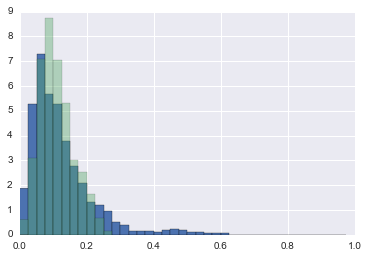

In [13]:
bins = np.arange(0,1,0.025)

bin_dat.loc[neg_mark_fil == False, ('stats', 'dremi_median')].hist(normed=1,bins=bins)
bin_dat.loc[neg_mark_fil, ('stats', 'dremi_median')].hist(normed=1, alpha=0.4,bins=bins)

maxneg_dremi = bin_dat.loc[neg_mark_fil, ('stats', 'dremi_median')].max()
maxneg_dremi_99 = np.percentile(bin_dat.loc[neg_mark_fil, ('stats', 'dremi_median')].dropna(),99,)
maxneg_dremi_90 = np.percentile(bin_dat.loc[neg_mark_fil, ('stats', 'dremi_median')].dropna(),90,)
print(bin_dat.loc[neg_mark_fil == False, ('stats', 'dremi_median')].max())
print(bin_dat.loc[neg_mark_fil, ('stats', 'dremi_median')].max())

print(maxneg_dremi)
print(np.sum(bin_dat.loc[neg_mark_fil == False, ('stats', 'dremi_median')] > maxneg_dremi)/3)
print(maxneg_dremi_99)
print(np.sum(bin_dat.loc[neg_mark_fil == False, ('stats', 'dremi_median')] > maxneg_dremi_99)/3)

0.600433051586
0.107025787234
0.107025787234
362.0
0.08167250067
531.0


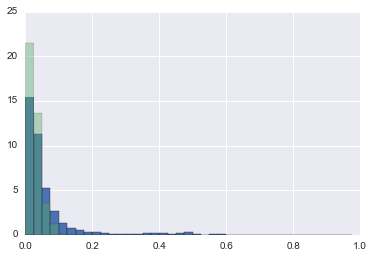

In [14]:
bin_dat['stats']
bins = np.arange(0,1,0.025)

bin_dat.loc[neg_mark_fil == False, ('stats', 'median_mean_var_ratio')].hist(normed=1,bins=bins)
bin_dat.loc[neg_mark_fil, ('stats', 'median_mean_var_ratio')].hist(normed=1, alpha=0.4,bins=bins)

maxneg_bp = bin_dat.loc[neg_mark_fil, ('stats', 'median_mean_var_ratio')].max()
maxneg_bp_99 = np.percentile(bin_dat.loc[neg_mark_fil, ('stats', 'median_mean_var_ratio')].dropna(),99)
maxneg_bp_90 = np.percentile(bin_dat.loc[neg_mark_fil, ('stats', 'median_mean_var_ratio')].dropna(),90)

print(bin_dat.loc[neg_mark_fil == False, ('stats', 'median_mean_var_ratio')].max())
print(bin_dat.loc[neg_mark_fil, ('stats', 'median_mean_var_ratio')].max())

print(maxneg_bp)
print(np.sum(bin_dat.loc[neg_mark_fil == False, ('stats', 'median_mean_var_ratio')] > maxneg_bp)/3)
print(maxneg_bp_99)
print(np.sum(bin_dat.loc[neg_mark_fil == False, ('stats', 'median_mean_var_ratio')] > maxneg_bp_99)/3)


In [15]:
maxneg_bp_99

0.081672500669956141

0.88376109691
0.302999088969
0.302999088969
458.0
0.08167250067
524.0


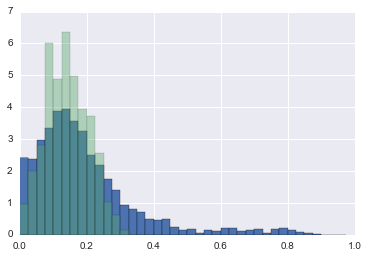

In [16]:
bin_dat['stats']
bins = np.arange(0,1,0.025)

bin_dat.loc[neg_mark_fil == False, ('stats', 'median_abs_corr_spearman_overall')].hist(normed=1,bins=bins)
bin_dat.loc[neg_mark_fil, ('stats', 'median_abs_corr_spearman_overall')].hist(normed=1, alpha=0.4,bins=bins)

maxneg_sp = bin_dat.loc[neg_mark_fil, ('stats', 'median_abs_corr_spearman_overall')].max()
maxneg_sp_99 = np.percentile(bin_dat.loc[neg_mark_fil, ('stats', 'median_abs_corr_spearman_overall')].dropna(),99,)
maxneg_sp_90 = np.percentile(bin_dat.loc[neg_mark_fil, ('stats', 'median_abs_corr_spearman_overall')].dropna(),90,)
print(bin_dat.loc[neg_mark_fil == False, ('stats', 'median_abs_corr_spearman_overall')].max())
print(bin_dat.loc[neg_mark_fil, ('stats', 'median_abs_corr_spearman_overall')].max())

print(maxneg_sp)
print(np.sum(bin_dat.loc[neg_mark_fil == False, ('stats', 'median_abs_corr_spearman_overall')] > maxneg_sp)/3)
print(maxneg_bp_99)
print(np.sum(bin_dat.loc[neg_mark_fil == False, ('stats', 'median_abs_corr_spearman_overall')] > maxneg_sp_99)/3)


0.902864
0.352638
0.352638
454.0
0.305756657124
530.0


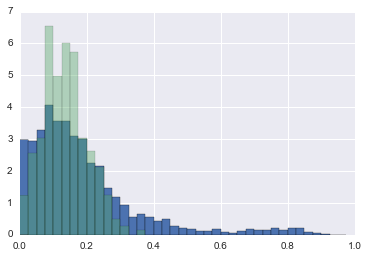

In [17]:
bin_dat['stats']
bins = np.arange(0,1,0.025)

bin_dat.loc[neg_mark_fil == False, ('stats', 'median_abs_corr_pearson_overall')].hist(normed=1,bins=bins)
bin_dat.loc[neg_mark_fil, ('stats', 'median_abs_corr_pearson_overall')].hist(normed=1, alpha=0.4,bins=bins)

maxneg_pc = bin_dat.loc[neg_mark_fil, ('stats', 'median_abs_corr_pearson_overall')].max()
maxneg_pc_99 = np.percentile(bin_dat.loc[neg_mark_fil, ('stats', 'median_abs_corr_pearson_overall')].dropna(),99,)
maxneg_pc_90 = np.percentile(bin_dat.loc[neg_mark_fil, ('stats', 'median_abs_corr_pearson_overall')].dropna(),90,)
print(bin_dat.loc[neg_mark_fil == False, ('stats', 'median_abs_corr_pearson_overall')].max())
print(bin_dat.loc[neg_mark_fil, ('stats', 'median_abs_corr_pearson_overall')].max())

print(maxneg_pc)
print(np.sum(bin_dat.loc[neg_mark_fil == False, ('stats', 'median_abs_corr_pearson_overall')] > maxneg_sp)/3)
print(maxneg_pc_99)
print(np.sum(bin_dat.loc[neg_mark_fil == False, ('stats', 'median_abs_corr_pearson_overall')] > maxneg_sp_99)/3)


In [18]:
#fil = bin_dat[('stats', 'dremi_median')] > 0.24
#fildat = bin_dat.loc[(fil) & (neg_mark_fil)]
#hits_dremi_GFP = set('_'.join([m, t, str(tp)]) for m, t, tp in
#             zip(fildat.reset_index()['marker'],fildat.reset_index()['target'],fildat.reset_index()['timepoint']))
#hits_dremi_GFP

Compare the overlap of hits between 

In [19]:
fil = bin_dat[('stats', 'dremi_median')] > maxneg_dremi_99
fildat = bin_dat.loc[(fil) & (neg_mark_fil == False)]

hits_dremi = set('_'.join([m, t, str(tp)]) for m, t, tp in
             zip(fildat.reset_index()['marker'],fildat.reset_index()['target'],fildat.reset_index()['timepoint']))

fil = bin_dat[('stats', 'median_mean_var_ratio')] > maxneg_bp_99
fildat = bin_dat.loc[(fil) & (neg_mark_fil == False)]

hits_bp = set('_'.join([m, t, str(tp)]) for m, t, tp in
             zip(fildat.reset_index()['marker'],fildat.reset_index()['target'],fildat.reset_index()['timepoint']))

fil = bin_dat[('stats', 'median_abs_corr_spearman_overall')] > maxneg_sp_99

fildat = bin_dat.loc[(fil) & (neg_mark_fil == False)]

hits_sp = set('_'.join([m, t, str(tp)]) for m, t, tp in
             zip(fildat.reset_index()['marker'],fildat.reset_index()['target'],fildat.reset_index()['timepoint']))

fil = bin_dat[('stats', 'median_abs_corr_pearson_overall')] > maxneg_pc_99

fildat = bin_dat.loc[(fil) & (neg_mark_fil == False)]

hits_pc = set('_'.join([m, t, str(tp)]) for m, t, tp in
             zip(fildat.reset_index()['marker'],fildat.reset_index()['target'],fildat.reset_index()['timepoint']))

Look at the different hits as a venn diagramm

<matplotlib_venn._common.VennDiagram instance at 0x7f0b7d91e200>

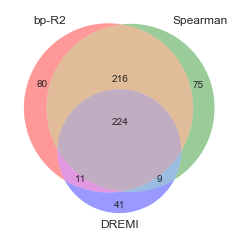

In [20]:
venn3([hits_bp,hits_sp,hits_dremi],set_labels=['bp-R2', 'Spearman', 'DREMI'])

-> This is  the supplementary figure 11 a)

<matplotlib_venn._common.VennDiagram instance at 0x7f0b7d8f43f8>

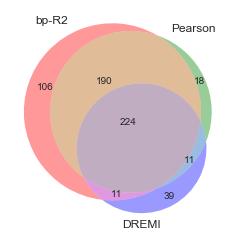

In [21]:
venn3([hits_bp,hits_pc,hits_dremi],set_labels=['bp-R2', 'Pearson', 'DREMI'])

## Look how exactly the hits differ

In [22]:
hits_bp

{'AKT1_Beta-catenin_0',
 'AKT1_Beta-catenin_15',
 'AKT1_Beta-catenin_30',
 'AKT1_Beta-catenin_5',
 'AKT1_Beta-catenin_60',
 'AKT1_p-AKT_0',
 'AKT1_p-AKT_15',
 'AKT1_p-AKT_30',
 'AKT1_p-AKT_5',
 'AKT1_p-AKT_60',
 'AKT1_p-BTK_0',
 'AKT1_p-BTK_15',
 'AKT1_p-BTK_30',
 'AKT1_p-BTK_5',
 'AKT1_p-BTK_60',
 'AKT1_p-GSK3-Beta_0',
 'AKT1_p-GSK3-Beta_15',
 'AKT1_p-GSK3-Beta_30',
 'AKT1_p-GSK3-Beta_5',
 'AKT1_p-GSK3-Beta_60',
 'AKT1_p-MKK3-6_0',
 'AKT1_p-MKK3-6_15',
 'AKT1_p-MKK3-6_30',
 'AKT1_p-MKK3-6_5',
 'AKT1_p-MKK3-6_60',
 'AKT1_p-PDPK1_0',
 'AKT1_p-PDPK1_30',
 'AKT1_p-PDPK1_5',
 'AKT1_p-PDPK1_60',
 'AKT1_p-SMAD1-5_0',
 'AKT1_p-SMAD1-5_30',
 'AKT1_p-SMAD1-5_5',
 'AKT1_p-SMAD1-5_60',
 'AKT1_p-SMAD2-3_0',
 'AKT1_p-SMAD2-3_15',
 'AKT1_p-SMAD2-3_30',
 'AKT1_p-SMAD2-3_5',
 'AKT1_p-SMAD2-3_60',
 'AKT1_p-p70S6K_0',
 'AKT1_p-p70S6K_15',
 'AKT1_p-p70S6K_30',
 'AKT1_p-p70S6K_5',
 'AKT1_p-p70S6K_60',
 'BRAF_p-JNK_15',
 'BRAF_p-JNK_30',
 'BRAF_p-JNK_60',
 'BRAF_p-MKK3-6_0',
 'BRAF_p-MKK3-6_15',
 'BRAF_p-M

In [23]:
hits_bp.difference(hits_dremi)

{'AKT1_Beta-catenin_0',
 'AKT1_Beta-catenin_15',
 'AKT1_Beta-catenin_60',
 'AKT1_p-AKT_0',
 'AKT1_p-BTK_0',
 'AKT1_p-BTK_15',
 'AKT1_p-BTK_30',
 'AKT1_p-BTK_5',
 'AKT1_p-BTK_60',
 'AKT1_p-GSK3-Beta_0',
 'AKT1_p-GSK3-Beta_15',
 'AKT1_p-GSK3-Beta_30',
 'AKT1_p-GSK3-Beta_5',
 'AKT1_p-GSK3-Beta_60',
 'AKT1_p-MKK3-6_0',
 'AKT1_p-MKK3-6_15',
 'AKT1_p-MKK3-6_30',
 'AKT1_p-MKK3-6_5',
 'AKT1_p-MKK3-6_60',
 'AKT1_p-PDPK1_0',
 'AKT1_p-PDPK1_30',
 'AKT1_p-PDPK1_5',
 'AKT1_p-PDPK1_60',
 'AKT1_p-SMAD1-5_0',
 'AKT1_p-SMAD1-5_30',
 'AKT1_p-SMAD1-5_5',
 'AKT1_p-SMAD2-3_0',
 'AKT1_p-SMAD2-3_15',
 'AKT1_p-SMAD2-3_30',
 'AKT1_p-SMAD2-3_5',
 'AKT1_p-SMAD2-3_60',
 'AKT1_p-p70S6K_0',
 'AKT1_p-p70S6K_15',
 'AKT1_p-p70S6K_30',
 'AKT1_p-p70S6K_5',
 'AKT1_p-p70S6K_60',
 'BRAF_p-MKK3-6_0',
 'BRAF_p-MKK3-6_15',
 'BRAF_p-MKK3-6_30',
 'BRAF_p-MKK3-6_5',
 'BRAF_p-MKK3-6_60',
 'BRAF_p-S6_15',
 'BRAF_p-SMAD1-5_15',
 'BRAF_p-p38_15',
 'CRAF_p-ERK1-2_5',
 'CRAF_p-JNK_0',
 'CRAF_p-JNK_5',
 'CRAF_p-PLCg2_5',
 'CRAF_p-S6_15

In [24]:
hits_bp.difference(hits_dremi.union(hits_sp))

{'AKT1_Beta-catenin_0',
 'AKT1_Beta-catenin_15',
 'AKT1_Beta-catenin_60',
 'AKT1_p-BTK_0',
 'AKT1_p-BTK_15',
 'AKT1_p-BTK_30',
 'AKT1_p-BTK_5',
 'AKT1_p-BTK_60',
 'AKT1_p-GSK3-Beta_0',
 'AKT1_p-GSK3-Beta_15',
 'AKT1_p-GSK3-Beta_30',
 'AKT1_p-GSK3-Beta_5',
 'AKT1_p-GSK3-Beta_60',
 'AKT1_p-SMAD2-3_0',
 'AKT1_p-SMAD2-3_15',
 'AKT1_p-SMAD2-3_30',
 'AKT1_p-SMAD2-3_5',
 'AKT1_p-SMAD2-3_60',
 'BRAF_p-S6_15',
 'CRAF_p-JNK_0',
 'CRAF_p-PLCg2_5',
 'CRAF_p-SMAD1-5_30',
 'GSK3B_E-cadherin_5',
 'GSK3B_p-BTK_30',
 'GSK3B_p-FAK_0',
 'GSK3B_p-FAK_15',
 'GSK3B_p-FAK_5',
 'GSK3B_p-MEK1-2_5',
 'GSK3B_p-S6_5',
 'GSK3B_p-p90RSK_5',
 'KRAS_p-ERK1-2_30',
 'KRAS_p-S6_60',
 'KRAS_p-p90RSK_30',
 'MAP2K1_Beta-catenin_60',
 'MAP2K1_p-BTK_0',
 'MAP2K1_p-BTK_30',
 'MAP2K1_p-BTK_60',
 'MAP2K1_p-GSK3-Beta_0',
 'MAP2K1_p-GSK3-Beta_30',
 'MAP2K1_p-GSK3-Beta_5',
 'MAP2K1_p-GSK3-Beta_60',
 'MAP2K1_p-MKK3-6_30',
 'MAP2K1_p-MKK3_30',
 'MAP2K1_p-MKK3_5',
 'MAP2K1_p-MKK3_60',
 'MAP2K1_p-SMAD1-5_30',
 'MAP2K1_p-SMAD1-5_60',
 

In [25]:
hits_bp.difference(hits_sp)

{'AKT1_Beta-catenin_0',
 'AKT1_Beta-catenin_15',
 'AKT1_Beta-catenin_30',
 'AKT1_Beta-catenin_5',
 'AKT1_Beta-catenin_60',
 'AKT1_p-BTK_0',
 'AKT1_p-BTK_15',
 'AKT1_p-BTK_30',
 'AKT1_p-BTK_5',
 'AKT1_p-BTK_60',
 'AKT1_p-GSK3-Beta_0',
 'AKT1_p-GSK3-Beta_15',
 'AKT1_p-GSK3-Beta_30',
 'AKT1_p-GSK3-Beta_5',
 'AKT1_p-GSK3-Beta_60',
 'AKT1_p-SMAD2-3_0',
 'AKT1_p-SMAD2-3_15',
 'AKT1_p-SMAD2-3_30',
 'AKT1_p-SMAD2-3_5',
 'AKT1_p-SMAD2-3_60',
 'BRAF_p-S6_0',
 'BRAF_p-S6_15',
 'CRAF_p-JNK_0',
 'CRAF_p-PLCg2_5',
 'CRAF_p-SMAD1-5_30',
 'GSK3B_E-cadherin_5',
 'GSK3B_p-BTK_30',
 'GSK3B_p-FAK_0',
 'GSK3B_p-FAK_15',
 'GSK3B_p-FAK_5',
 'GSK3B_p-MEK1-2_5',
 'GSK3B_p-S6_5',
 'GSK3B_p-p90RSK_5',
 'KRAS_p-ERK1-2_30',
 'KRAS_p-S6_15',
 'KRAS_p-S6_60',
 'KRAS_p-p90RSK_30',
 'MAP2K1_Beta-catenin_0',
 'MAP2K1_Beta-catenin_5',
 'MAP2K1_Beta-catenin_60',
 'MAP2K1_p-BTK_0',
 'MAP2K1_p-BTK_30',
 'MAP2K1_p-BTK_60',
 'MAP2K1_p-GSK3-Beta_0',
 'MAP2K1_p-GSK3-Beta_30',
 'MAP2K1_p-GSK3-Beta_5',
 'MAP2K1_p-GSK3-Beta_60',


In [26]:
hits_dremi.difference(hits_bp)


{'AKT1_p-S6_0',
 'AKT1_p-S6_5',
 'BRAF_p-SMAD1-5_60',
 'CRAF_p-AKT_15',
 'CRAF_p-AKT_5',
 'CRAF_p-AKT_60',
 'GSK3B_p-SMAD1-5_30',
 'HRAS_p-S6_15',
 'KRAS_p-PLCg2_5',
 'KRAS_p-S6_5',
 'MAP2K1_p-S6_0',
 'MAP2K1_p-S6_15',
 'MAP2K1_p-S6_30',
 'MAP2K6_Beta-catenin_0',
 'MAP2K6_Beta-catenin_15',
 'MAP2K6_Beta-catenin_30',
 'MAP2K6_Beta-catenin_5',
 'MAP2K6_Beta-catenin_60',
 'MAP2K6_E-cadherin_5',
 'MAP2K6_p-CREB_15',
 'MAP2K6_p-CREB_30',
 'MAP2K6_p-CREB_5',
 'MAP2K6_p-MARCKS_15',
 'MAP2K6_p-MARCKS_60',
 'MAP3K5_Beta-catenin_0',
 'MAP3K5_Beta-catenin_5',
 'MAP3K5_Beta-catenin_60',
 'MAP8_p-NfkB_5',
 'MAP8_p-PLCg2_0',
 'MAP8_p-PLCg2_30',
 'MAP8_p-PLCg2_5',
 'MAP8_p-PLCg2_60',
 'MAP8_p-S6_5',
 'MAP8_p-S6_60',
 'MAP8_p-STAT3_0',
 'MAP8_p-STAT3_60',
 'MAPK14_p-S6_15',
 'MAPK14_p-S6_30',
 'MAPK1_p-SMAD1-5_15',
 'PDPK1_E-cadherin_30',
 'PDPK1_E-cadherin_60',
 'PDPK1_p-AKT_0',
 'PTPN11_p-MARCKS_0',
 'PTPN11_p-S6_15',
 'RPS6KB1_p-S6_60',
 'SRC_Beta-catenin_0',
 'SRC_Beta-catenin_30',
 'SRC_E-cadheri

In [27]:
hits_dremi.difference(hits_bp.union(hits_sp))

{'AKT1_p-S6_0',
 'AKT1_p-S6_5',
 'CRAF_p-AKT_15',
 'CRAF_p-AKT_5',
 'CRAF_p-AKT_60',
 'GSK3B_p-SMAD1-5_30',
 'HRAS_p-S6_15',
 'KRAS_p-PLCg2_5',
 'KRAS_p-S6_5',
 'MAP2K1_p-S6_0',
 'MAP2K1_p-S6_15',
 'MAP2K1_p-S6_30',
 'MAP2K6_Beta-catenin_0',
 'MAP2K6_Beta-catenin_15',
 'MAP2K6_Beta-catenin_30',
 'MAP2K6_Beta-catenin_5',
 'MAP2K6_Beta-catenin_60',
 'MAP2K6_E-cadherin_5',
 'MAP2K6_p-CREB_15',
 'MAP2K6_p-CREB_30',
 'MAP2K6_p-CREB_5',
 'MAP2K6_p-MARCKS_15',
 'MAP2K6_p-MARCKS_60',
 'MAP3K5_Beta-catenin_0',
 'MAP3K5_Beta-catenin_5',
 'MAP3K5_Beta-catenin_60',
 'MAP8_p-NfkB_5',
 'MAP8_p-S6_5',
 'MAP8_p-S6_60',
 'MAPK14_p-S6_15',
 'MAPK14_p-S6_30',
 'MAPK1_p-SMAD1-5_15',
 'PDPK1_E-cadherin_30',
 'PDPK1_E-cadherin_60',
 'PDPK1_p-AKT_0',
 'RPS6KB1_p-S6_60',
 'SRC_Beta-catenin_0',
 'SRC_Beta-catenin_30',
 'SRC_E-cadherin_30',
 'SRC_E-cadherin_60',
 'SRC_p-CREB_15'}

In [28]:
hits_dremi.difference(hits_sp)

{'AKT1_Beta-catenin_30',
 'AKT1_Beta-catenin_5',
 'AKT1_p-S6_0',
 'AKT1_p-S6_5',
 'BRAF_p-S6_0',
 'CRAF_p-AKT_15',
 'CRAF_p-AKT_5',
 'CRAF_p-AKT_60',
 'GSK3B_p-SMAD1-5_30',
 'HRAS_p-S6_15',
 'KRAS_p-PLCg2_5',
 'KRAS_p-S6_15',
 'KRAS_p-S6_5',
 'MAP2K1_Beta-catenin_0',
 'MAP2K1_Beta-catenin_5',
 'MAP2K1_p-MARCKS_5',
 'MAP2K1_p-MKK3-6_0',
 'MAP2K1_p-MKK3-6_60',
 'MAP2K1_p-S6_0',
 'MAP2K1_p-S6_15',
 'MAP2K1_p-S6_30',
 'MAP2K1_p-p90RSK_15',
 'MAP2K6_Beta-catenin_0',
 'MAP2K6_Beta-catenin_15',
 'MAP2K6_Beta-catenin_30',
 'MAP2K6_Beta-catenin_5',
 'MAP2K6_Beta-catenin_60',
 'MAP2K6_E-cadherin_5',
 'MAP2K6_p-CREB_15',
 'MAP2K6_p-CREB_30',
 'MAP2K6_p-CREB_5',
 'MAP2K6_p-MARCKS_15',
 'MAP2K6_p-MARCKS_60',
 'MAP3K5_Beta-catenin_0',
 'MAP3K5_Beta-catenin_5',
 'MAP3K5_Beta-catenin_60',
 'MAP8_p-NfkB_5',
 'MAP8_p-S6_5',
 'MAP8_p-S6_60',
 'MAPK14_p-S6_15',
 'MAPK14_p-S6_30',
 'MAPK1_p-SMAD1-5_15',
 'PDPK1_E-cadherin_30',
 'PDPK1_E-cadherin_60',
 'PDPK1_p-AKT_0',
 'RPS6KB1_p-S6_30',
 'RPS6KB1_p-S6_60'

In [29]:
hits_sp.difference(hits_bp)

{'AKT1_p-PDPK1_15',
 'AKT1_p-SMAD1-5_15',
 'AKT1_p-STAT5_0',
 'AKT1_p-STAT5_30',
 'AKT1_p-STAT5_5',
 'AKT1_p-p38_5',
 'BRAF_p-JNK_0',
 'BRAF_p-JNK_5',
 'BRAF_p-SMAD1-5_60',
 'BRAF_p-p38_5',
 'BRAF_p-p90RSK_60',
 'CRAF_p-ERK1-2_0',
 'CRAF_p-JNK_15',
 'CRAF_p-PLCg2_15',
 'GSK3B_E-cadherin_60',
 'HRAS_p-MAPKAPK2_15',
 'HRAS_p-MAPKAPK2_30',
 'HRAS_p-MAPKAPK2_60',
 'HRAS_p-p38_0',
 'HRAS_p-p38_60',
 'KRAS_Beta-catenin_5',
 'KRAS_p-MKK3-6_5',
 'KRAS_p-SMAD1-5_15',
 'KRAS_p-SMAD1-5_30',
 'KRAS_p-SMAD1-5_5',
 'KRAS_p-SMAD1-5_60',
 'MAP2K6_p-MKK3_15',
 'MAP2K6_p-SMAD1-5_0',
 'MAP2K7_p-ERK1-2_60',
 'MAP2K7_p-STAT5_0',
 'MAP2K7_p-p38_60',
 'MAP3K5_p-MKK3_60',
 'MAP3K5_p-p70S6K_0',
 'MAP3K5_p-p70S6K_30',
 'MAP3K5_p-p70S6K_60',
 'MAP3K5_p-p90RSK_60',
 'MAP8_p-PDPK1_5',
 'MAP8_p-PLCg2_0',
 'MAP8_p-PLCg2_30',
 'MAP8_p-PLCg2_5',
 'MAP8_p-PLCg2_60',
 'MAP8_p-SMAD2-3_0',
 'MAP8_p-SMAD2-3_15',
 'MAP8_p-SMAD2-3_30',
 'MAP8_p-STAT3_0',
 'MAP8_p-STAT3_5',
 'MAP8_p-STAT3_60',
 'MAP8_p-STAT5_0',
 'MAP8_p-p70S

In [30]:
hits_sp.difference(hits_bp.union(hits_dremi))

{'AKT1_p-PDPK1_15',
 'AKT1_p-SMAD1-5_15',
 'AKT1_p-STAT5_0',
 'AKT1_p-STAT5_30',
 'AKT1_p-STAT5_5',
 'AKT1_p-p38_5',
 'BRAF_p-JNK_0',
 'BRAF_p-JNK_5',
 'BRAF_p-p38_5',
 'BRAF_p-p90RSK_60',
 'CRAF_p-ERK1-2_0',
 'CRAF_p-JNK_15',
 'CRAF_p-PLCg2_15',
 'GSK3B_E-cadherin_60',
 'HRAS_p-MAPKAPK2_15',
 'HRAS_p-MAPKAPK2_30',
 'HRAS_p-MAPKAPK2_60',
 'HRAS_p-p38_0',
 'HRAS_p-p38_60',
 'KRAS_Beta-catenin_5',
 'KRAS_p-MKK3-6_5',
 'KRAS_p-SMAD1-5_15',
 'KRAS_p-SMAD1-5_30',
 'KRAS_p-SMAD1-5_5',
 'KRAS_p-SMAD1-5_60',
 'MAP2K6_p-MKK3_15',
 'MAP2K6_p-SMAD1-5_0',
 'MAP2K7_p-ERK1-2_60',
 'MAP2K7_p-STAT5_0',
 'MAP2K7_p-p38_60',
 'MAP3K5_p-MKK3_60',
 'MAP3K5_p-p70S6K_0',
 'MAP3K5_p-p70S6K_30',
 'MAP3K5_p-p70S6K_60',
 'MAP3K5_p-p90RSK_60',
 'MAP8_p-PDPK1_5',
 'MAP8_p-SMAD2-3_0',
 'MAP8_p-SMAD2-3_15',
 'MAP8_p-SMAD2-3_30',
 'MAP8_p-STAT3_5',
 'MAP8_p-STAT5_0',
 'MAP8_p-p70S6K_30',
 'MAPK14_p-ERK1-2_5',
 'MAPK14_p-ERK1-2_60',
 'MAPK14_p-STAT5_5',
 'MAPK14_p-p90RSK_5',
 'MAPK14_p-p90RSK_60',
 'MAPK1_p-AMPKalpha_

In [31]:
hits_bp.union(hits_sp).difference(hits_dremi)

{'AKT1_Beta-catenin_0',
 'AKT1_Beta-catenin_15',
 'AKT1_Beta-catenin_60',
 'AKT1_p-AKT_0',
 'AKT1_p-BTK_0',
 'AKT1_p-BTK_15',
 'AKT1_p-BTK_30',
 'AKT1_p-BTK_5',
 'AKT1_p-BTK_60',
 'AKT1_p-GSK3-Beta_0',
 'AKT1_p-GSK3-Beta_15',
 'AKT1_p-GSK3-Beta_30',
 'AKT1_p-GSK3-Beta_5',
 'AKT1_p-GSK3-Beta_60',
 'AKT1_p-MKK3-6_0',
 'AKT1_p-MKK3-6_15',
 'AKT1_p-MKK3-6_30',
 'AKT1_p-MKK3-6_5',
 'AKT1_p-MKK3-6_60',
 'AKT1_p-PDPK1_0',
 'AKT1_p-PDPK1_15',
 'AKT1_p-PDPK1_30',
 'AKT1_p-PDPK1_5',
 'AKT1_p-PDPK1_60',
 'AKT1_p-SMAD1-5_0',
 'AKT1_p-SMAD1-5_15',
 'AKT1_p-SMAD1-5_30',
 'AKT1_p-SMAD1-5_5',
 'AKT1_p-SMAD2-3_0',
 'AKT1_p-SMAD2-3_15',
 'AKT1_p-SMAD2-3_30',
 'AKT1_p-SMAD2-3_5',
 'AKT1_p-SMAD2-3_60',
 'AKT1_p-STAT5_0',
 'AKT1_p-STAT5_30',
 'AKT1_p-STAT5_5',
 'AKT1_p-p38_5',
 'AKT1_p-p70S6K_0',
 'AKT1_p-p70S6K_15',
 'AKT1_p-p70S6K_30',
 'AKT1_p-p70S6K_5',
 'AKT1_p-p70S6K_60',
 'BRAF_p-JNK_0',
 'BRAF_p-JNK_5',
 'BRAF_p-MKK3-6_0',
 'BRAF_p-MKK3-6_15',
 'BRAF_p-MKK3-6_30',
 'BRAF_p-MKK3-6_5',
 'BRAF_p-MKK3-

In [32]:
hits_bp.intersection(hits_dremi).difference(hits_sp)

{'AKT1_Beta-catenin_30',
 'AKT1_Beta-catenin_5',
 'BRAF_p-S6_0',
 'KRAS_p-S6_15',
 'MAP2K1_Beta-catenin_0',
 'MAP2K1_Beta-catenin_5',
 'MAP2K1_p-MARCKS_5',
 'MAP2K1_p-MKK3-6_0',
 'MAP2K1_p-MKK3-6_60',
 'MAP2K1_p-p90RSK_15',
 'RPS6KB1_p-S6_30'}

## Make a table of the hits and save it 

In [33]:
hit_dict = dict()

hit_dict['all_hits'] = list(set(list(hits_sp)+ list(hits_dremi)+ list(hits_bp)))
hit_dict['is_bp'] = [h in hits_bp for h in hit_dict['all_hits'] ]
hit_dict['is_sp'] = [h in hits_sp for h in hit_dict['all_hits'] ]
hit_dict['is_dremi'] = [h in hits_dremi for h in hit_dict['all_hits'] ]


hit_tab = pd.DataFrame.from_dict(hit_dict)
#hit_tab = hit_tab.set_index('all_hits')

hit_tab = hit_tab.sort_values(by=['is_bp','is_dremi', 'is_sp'],ascending=False)

hit_tab.to_csv(os.path.join(out_folder,'20160429_readout_comparison_vsemptygfp_woCC.csv'),index=False)